*Week 1 Velocity distributions:*

Background:
Irrespective of the start conditions, velocity distributions in multi-particle systems with
collisions between particles converge to a Maxwell-Boltzmann distribution. We will
investigate this effect by creating our own simulation of a multi-particle systems of
hard spheres in a 2D-box.

**Task I - Implementation**
In this first section will outline how we created an algorythm for simulating hard spheres in a box that includes 
* elastic collisions of hard spheres
* multi particle systems
* periodic boundary conditions for the box

All the code will be provided in easy to use functions that will be called for Task II.



Importing all external libraries used in this code

In [1]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

import copy
import numpy as np
import scipy as scy

Creating a particle class:

In [2]:
class Particle:
    def __init__(self, r, x, y, vx, vy):
        self.r = r
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy
        
    def __repr__(self):
        return str("This is a particle at %0.2f, %0.2f with v=%0.2f,%0.2f" % (self.x,self.y,self.vx,self.vy))

Defining the parameters used in the simulation later on


In [3]:
# defining the box
box_size_x = 20
box_size_y = 20

box = [box_size_x,box_size_y]

In [4]:
# defining the number of particles and their corresponding radius
number_of_particles = 50
radius = 0.5

In [5]:
# Initialising the velocities
baseline_velocity = 0.5 # same velocity magnitude for all particles 

# random direction of the velocity in 2D for each particle
vel = np.ones(number_of_particles) * baseline_velocity
angles = np.random.uniform(0,2 * np.pi, number_of_particles)

In [6]:
# Initialising the positions
# random positions for each particle
x_rand = np.random.randint(1,box[0]-1,number_of_particles)
y_rand = np.random.randint(1,box[1]-1,number_of_particles)


In [7]:
# Setting up the particle:
# Each particle gets assigned a position (x,y) and a velocity (v_x, v_y).
particles = []
for i in range(number_of_particles):
    particles.append(Particle(radius,x_rand[i],y_rand[i],np.sin(angles[i]) * vel[i],np.cos(angles[i]) * vel[i]))

In [8]:
# Defining number of simulation steps
steps = 50

Initialise trajectory:

In [9]:
data_traj = np.zeros((number_of_particles,4,steps))
data_traj.shape

(50, 4, 50)

Euler integrator scheme:
Define time integrator for numerical, stepwise solution of equation of motion with a discrete time step $dt$:

In [10]:
# define time step dt for simulation
dt = 1

def move(p,dt):
    p.x = p.x + p.vx * dt
    p.y = p.y + p.vy * dt
    return p

Define a move function to move particles for each time step.

In [11]:
def move_unbound(p,dt):
    p.x = np.mod(p.x + p.vx * dt, box_size_x)
    p.y = np.mod(p.y + p.vy * dt, box_size_y)
    return p

Define box reflection:

In [12]:
def reflect(p):
    if (p.x + p.r) >= box[0]:
        p.vx = p.vx * (-1)
    if (p.x) <= p.r:
        p.vx = p.vx * (-1)
    if (p.y + p.r) >= box[1]:
        p.vy = p.vy * (-1)
    if (p.y) <= p.r:
        p.vy = p.vy * (-1)
    return p

Define a function that calculates new velocities for two particles (with the same mass) colliding with two different velocities in 2D. The formulas can be found here: 
 https://hermann-baum.de/elastischer_stoss/, 24.10.2024.


In [13]:
def collide_simple(particles):
    for i in range(len(particles)): # looping through all particles
        for j in range(len(particles)):
            if i < j:
                distance = np.sqrt(np.abs(particles[i].x-particles[j].x)**2+np.abs(particles[i].y-particles[j].y)**2)
                if distance<(particles[i].r+particles[j].r):
                    # calculate angle between x-axis and line between particles
                    phi = np.arctan((particles[j].y - particles[i].y)/(particles[j].x - particles[i].x))
                    # change the velocities
                    particles[i].vx = ( particles[i].vx*np.sin(phi)-particles[i].vy*np.cos(phi))*np.sin(phi)+(particles[j].vx*np.cos(phi)+particles[j].vy*np.sin(phi))*np.cos(phi)
                    particles[i].vy = (-particles[i].vx*np.sin(phi)+particles[i].vy*np.cos(phi))*np.cos(phi)+(particles[j].vx*np.cos(phi)+particles[j].vy*np.sin(phi))*np.sin(phi)
                    particles[j].vx = ( particles[j].vx*np.sin(phi)-particles[j].vy*np.cos(phi))*np.sin(phi)+(particles[i].vx*np.cos(phi)+particles[i].vy*np.sin(phi))*np.cos(phi)
                    particles[j].vy = (-particles[j].vx*np.sin(phi)+particles[j].vy*np.cos(phi))*np.cos(phi)+(particles[i].vx*np.cos(phi)+particles[i].vy*np.sin(phi))*np.sin(phi)
                    #print(particles[i],particles[j],'collided with a distance of ', distance)


Define a function to take into account particles colliding due to the periodic boundary conditions. This will be done as follows: Firstly particles will be moved by a time step $dt$. Secondly it will be checked if the particles have collided. If so their positions will be reset to where the particles just touch one another. At this point the collision function will calculate new velocities and their corresponding directions for the particles in the subsequent time step. To take into account the periodic boundary conditions the particles in the left border region of the box will be moved to the right side outside of the box. Again collisions will be detected for these particles and new velocities calculated. Finally the periodic boun dary condition will be applied.

In [14]:
# check if particles are in border area
# if a particle is in the left border area (smaller than one radius distance) it will be moved to the right outside of the box. Same for the bottom of the box.
def border_control(particles, radius, box_size_x, box_size_y):
    # for i in range(len(particles)):
    #     for j in range(len(particles)):
            if  particles.x < (box_size_x - radius):
                particles.x = particles.x + box_size_x
            if  particles.y < (box_size_y - radius):
                particles.y = particles.y + box_size_y
  
particles[0].x = 9.6
particles[0].y = 5
particles[0].vx = 0.4
particles[0].vy = 0  

b = border_control(particles[0], 0.5, 10, 10)            

print(particles[0])

This is a particle at 9.60, 15.00 with v=0.40,0.00


In [15]:
# https://hermann-baum.de/elastischer_stoss/
def calculate_distance(particle_1, particle_2):
    distance = np.sqrt(np.abs(particle_1.x - particle_2.x)**2+np.abs(particle_1.y - particle_2.y)**2)
    return distance


def collide_boundary(particles,data_traj,step, dt):
    for i in range(len(particles)):
        for j in range(len(particles)):
            if i < j:
                #print(i,j)
                distance_vector = np.array([particles[j].x-particles[i].x,particles[j].y-particles[i].y])# von i nach j
                distance = np.sqrt(np.abs(distance_vector[0])**2+np.abs(distance_vector[1])**2)
                R = particles[i].r+particles[j].r
                if distance<R:
                    print(step)
                    print(particles[i],particles[j],'collided with a distance of ', distance)
                    # angle between x-axis and line between particles
                    phi = np.arctan((particles[j].y - particles[i].y)/(particles[j].x - particles[i].x))
                    '''
                    # calculate vectors that point to the last timestep
                    backward_i = np.array([data_traj[i][0][step-1]-particles[i].x,data_traj[i][1][step-1]-particles[i].y])
                    backward_j = np.array([data_traj[j][0][step-1]-particles[j].x,data_traj[j][1][step-1]-particles[j].y])

                    # angles between the those vectors and their connecting vector
                    alpha_i = np.pi/2-np.arccos(np.dot(distance_vector,backward_i))
                    alpha_j = np.pi/2-np.arccos(np.dot(-distance_vector,backward_j))

                    # length of how much back we must go
                    s = (particles[j].r+particles[j].r-distance)/(alpha_i+alpha_j)

                    # relative
                    delta_s = s/np.sqrt(np.abs(backward_i[0])**2+np.abs(backward_i[1])**2)
                    '''
                    # in time
                    #print(particles[i].vx-particles[j].vx)
                    v_x = particles[i].vx-particles[j].vx
                    v_y = particles[i].vy-particles[j].vy

                    r_x = particles[j].x-particles[i].x
                    r_y = particles[j].y-particles[i].y

                    print(v_x,v_y,r_x,r_y)
                    #print(diff_v, diff_r)
                    sqrt = 2*np.sqrt((r_x*v_x+r_y*v_y)**2-(v_x**2+v_y**2)*(r_x**2+r_y**2-R**2))
                    print(sqrt)
                    delta_t = -1*(-2*(r_x*v_x+r_y*v_y) + sqrt)/(2*(v_x**2+v_y**2))
                    
                    print(delta_t)
                    if delta_t > 0:
                        delta_t = -1*(-2*(r_x*v_x+r_y*v_y) - sqrt)/(2*(v_x**2+v_y**2))
                        print(True, delta_t)
                    
                    

                    #delta_t = delta_t

                    # rewind time to just outside of the collision
                    particles[i].x = np.mod(particles[i].x + particles[i].vx*delta_t,box_size_x)
                    particles[i].y = np.mod(particles[i].y + particles[i].vy*delta_t,box_size_y)
                    particles[j].x = np.mod(particles[j].x + particles[j].vx*delta_t,box_size_x)
                    particles[j].y = np.mod(particles[j].y + particles[j].vy*delta_t,box_size_y)

                    #debugging
                    distance = np.sqrt(np.abs(particles[i].x-particles[j].x)**2+np.abs(particles[i].y-particles[j].y)**2)
                    print(particles[i],particles[j],'collided with a distance of ', distance)

                    #used chatGPT for debugging
                    # change the velocities

                    # only calculate once, used multiple times
                    sin_phi = np.sin(phi)
                    cos_phi = np.cos(phi)

                    # Get the velocities of particles i and j as variables
                    v1x, v1y = particles[i].vx, particles[i].vy
                    v2x, v2y = particles[j].vx, particles[j].vy

                    # Calculate the updated velocities using the provided formulas: https://hermann-baum.de/elastischer_stoss/
                    new_v1x = (v1x * sin_phi - v1y * cos_phi) * sin_phi + (v2x * cos_phi + v2y * sin_phi) * cos_phi
                    new_v1y = (-v1x * sin_phi + v1y * cos_phi) * cos_phi + (v2x * cos_phi + v2y * sin_phi) * sin_phi
                    new_v2x = (v2x * sin_phi - v2y * cos_phi) * sin_phi + (v1x * cos_phi + v1y * sin_phi) * cos_phi
                    new_v2y = (-v2x * sin_phi + v2y * cos_phi) * cos_phi + (v1x * cos_phi + v1y * sin_phi) * sin_phi

                    # Update the particles' velocities
                    particles[i].vx, particles[i].vy = new_v1x, new_v1y
                    particles[j].vx, particles[j].vy = new_v2x, new_v2y
                    
                    # just for debugging
                    distance = np.sqrt(np.abs(particles[i].x-particles[j].x)**2+np.abs(particles[i].y-particles[j].y)**2)
                    print(particles[i],particles[j],'collided with a distance of ', distance)

                    # finish this time_step, that was rewound previously
                    particles[i].x = np.mod(particles[i].x - particles[i].vx*delta_t,box_size_x)
                    particles[i].y = np.mod(particles[i].y - particles[i].vy*delta_t,box_size_y)
                    particles[j].x = np.mod(particles[j].x - particles[j].vx*delta_t,box_size_x)
                    particles[j].y = np.mod(particles[j].y - particles[j].vy*delta_t,box_size_y)
                    # debugging
                    distance = np.sqrt(np.abs(particles[i].x-particles[j].x)**2+np.abs(particles[i].y-particles[j].y)**2)
                    print(particles[i],particles[j],'collided with a distance of ', distance)
                    

In [16]:
# particles[0].x = 5
# particles[0].y = 10
# particles[0].vx = 0.4
# particles[0].vy = 0
# 
# particles[1].x = 15
# particles[1].y = 10
# particles[1].vx = -0.4
# particles[1].vy = 0
# 
# particles[2].x = 10
# particles[2].y = 14.5
# particles[2].vx = 0
# particles[2].vy = -0.4
# 
# print(particles)

**Task II - Carrying out the simulation**
In the following the above functions will be implemented to run a simulation

In [17]:

for i in range(steps):
    for j in range(number_of_particles):
        #move(p1,1)
        #reflect(p1)
        move_unbound(particles[j],1)
        collide_boundary(particles,data_traj,i,dt)    
        for j in range(number_of_particles):
            data_traj[j,:,i] = [particles[j].x, particles[j].y, particles[j].vx, particles[j].vy]
        

0
This is a particle at 10.00, 15.00 with v=0.40,0.00 This is a particle at 10.00, 15.00 with v=0.31,0.39 collided with a distance of  0.0
0.08931990886401109 -0.3917625313525192 0.0 0
0.8036315750173305
-2.4887026122099165
This is a particle at 9.00, 15.00 with v=0.40,0.00 This is a particle at 9.23, 14.03 with v=0.31,0.39 collided with a distance of  0.9999999999999994
This is a particle at 9.00, 15.00 with v=nan,nan This is a particle at 9.23, 14.03 with v=nan,nan collided with a distance of  0.9999999999999994
This is a particle at nan, nan with v=nan,nan This is a particle at nan, nan with v=nan,nan collided with a distance of  nan
0
This is a particle at 13.00, 3.00 with v=-0.49,0.11 This is a particle at 13.00, 3.00 with v=-0.38,-0.32 collided with a distance of  0.0
-0.1025610878291125 0.43121126531122744 0 0
0.8864805289863974
-2.256112722844349
This is a particle at 14.10, 2.75 with v=-0.49,0.11 This is a particle at 13.87, 3.72 with v=-0.38,-0.32 collided with a distance of 

<ipython-input-15-4d3c848bc91a>:19: RuntimeWarning: invalid value encountered in true_divide
  phi = np.arctan((particles[j].y - particles[i].y)/(particles[j].x - particles[i].x))
<ipython-input-15-4d3c848bc91a>:19: RuntimeWarning: invalid value encountered in long_scalars
  phi = np.arctan((particles[j].y - particles[i].y)/(particles[j].x - particles[i].x))



This is a particle at 6.88, 12.87 with v=0.14,-0.50 This is a particle at 7.65, 12.88 with v=0.42,0.36 collided with a distance of  0.7758570893674628
-0.2756401648096788 -0.8645787877852864 0.7758517141418553 0.0028880417060754837
1.2240733461083717
-1.0059692551019086
This is a particle at 6.74, 13.38 with v=0.14,-0.50 This is a particle at 7.23, 12.51 with v=0.42,0.36 collided with a distance of  1.0000000000000004
This is a particle at 6.74, 13.38 with v=0.42,-0.50 This is a particle at 7.23, 12.51 with v=0.14,0.36 collided with a distance of  1.0000000000000004
This is a particle at 7.16, 12.87 with v=0.42,-0.50 This is a particle at 7.37, 12.87 with v=0.14,0.36 collided with a distance of  0.21481485055371216
0
This is a particle at 7.16, 12.87 with v=0.42,-0.50 This is a particle at 7.37, 12.87 with v=0.14,0.36 collided with a distance of  0.21481485055371216
0.28206907829524297 -0.8625027627864472 0.21481336229214776 0.0007996243844203832
1.7765840717438504
-1.0059692551019086

In [18]:
#data_traj

* Plotting trajectory with Matplotlib:

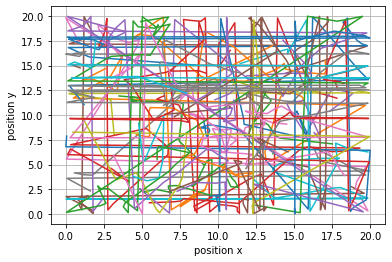

In [19]:
for data_traj_j in data_traj:
    plt.plot(data_traj_j[0],data_traj_j[1],'-')
plt.xlabel('position x')
plt.ylabel('position y')

plt.grid()
plt.show()

**Animate trajectory:**

* Set up the figure, the axis, and the plot element we want to animate

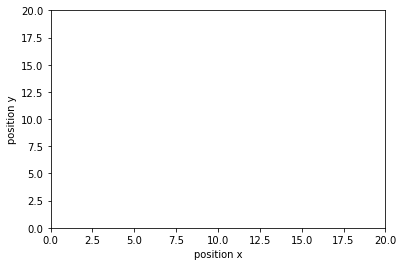

In [20]:
fig, ax = plt.subplots()

ax.set_xlim((0, box[0]))
ax.set_ylim((0, box[1]))

plt.xlabel('position x')
plt.ylabel('position y')

# make the points in the plot the correct size according to the radius of the particles
# use ax.transData.transform to convert radius size from particle to markerSize from pyplot
desired_size_in_data_units = radius
data_to_points = ax.transData.transform((desired_size_in_data_units, 0)) - ax.transData.transform((0, 0))
marker_size_in_points = data_to_points[0]


dot, = ax.plot([], [], 'bo', ms=marker_size_in_points)


#ax.plot(5,5, 'bo', ms=marker_size_in_points)
# dont show the plot 
#plt.close()

In [21]:
# * initialization function: plot the background of each frame
def init():
    dot.set_data([], [])
    return (dot,)

In [22]:
data_traj[:,0,1]
# data_traj [simulation_iterations, (x, y, v_x, v_y), particle]

array([        nan,  2.20916452,  3.9912491 , 10.59155302, 17.65254807,
       14.88909775,  0.66958621,  1.23218575,  3.15444748, 12.56960849,
        9.1089583 , 17.06436729, 17.01416155,  6.03015811, 14.52291304,
       14.17386152,  6.43443965,         nan,         nan, 11.90279381,
        8.00690949, 13.39563118,  5.51746369, 17.77808407, 10.265705  ,
        6.9898243 , 12.67919015, 12.24196887,  1.1674898 ,         nan,
       15.76088691,  4.95742385, 12.96819612,  9.20541504, 10.29797967,
       12.40425868, 14.01407098,  8.77271328, 19.97752552,  4.89807966,
       15.04133809,         nan,  6.00108109,  6.29151908, 11.0597912 ,
        7.21384626,  3.34749986,  0.13991092,         nan,  1.92638769])

In [23]:
# animation function. This is called sequentially
def animate(i):
    x = data_traj[:,0,i]
    y = data_traj[:,1,i]
    dot.set_data(x, y)
    return (dot,)


* call the animator. blit=True means only re-draw the parts that have changed.

In [24]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=steps, interval=60, blit=True)

In [25]:
HTML(anim.to_html5_video())
anim.save('animation.mp4', writer='ffmpeg', fps=30)


***Task III - analysis of the velocity distributions:***

Finally the results from the above simulation can be analysed.

Analysis of the velocity distribution in x direction

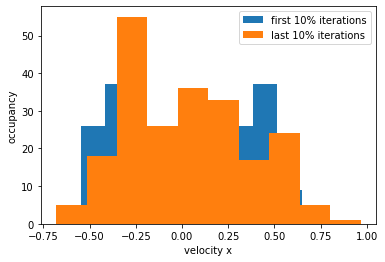

In [26]:

#print(data_traj [:, (1), :])

a = []
for i in range(np.int(0.1 *steps)):
    for j in range(number_of_particles):
        a.append(data_traj[j,2,i])

b = []
i_0 = np.int(0.9 * steps)-1
for i in range(np.int(0.1 * steps)):
    i = i+i_0
    
    for j in range(number_of_particles):
        b.append(data_traj[j,2,i])
    i = i+1

# print(a)
plt.hist(a,bins=10, label = 'first 10% iterations')
plt.hist(b,bins=10, label = 'last 10% iterations')
plt.xlabel('velocity x')
plt.ylabel('occupancy')
plt.legend()
plt.show()


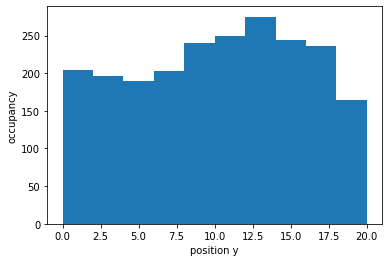

In [27]:
# histogram of the y positions

a = []
for i in range(steps):
    for j in range(number_of_particles):
        a.append((data_traj)[j, 1, i])

plt.hist(a,range=(0,box[0]),bins=10)
plt.xlabel('position y')
plt.ylabel('occupancy')
plt.show()

Analysis of the velocity distribution in the x direction

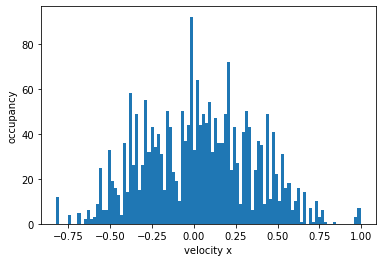

In [28]:
# plt.hist(data_traj[1],range=(0,box[1]),bins=3)
# plt.xlabel('position y')
# plt.ylabel('occupancy')
# plt.show()

# histogram of the x velocity

a = []
for i in range(steps):
    for j in range(number_of_particles):
        a.append((data_traj)[j, 2, i])
    
plt.hist(a,bins=100)
plt.xlabel('velocity x')
plt.ylabel('occupancy')
plt.show()

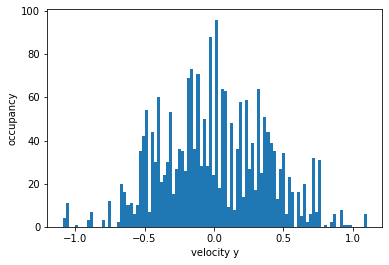

In [29]:
# histogram of the y velocity

a = []
for i in range(steps):
    for j in range(number_of_particles):
        a.append((data_traj)[j, 3, i])
    
plt.hist(a,bins=100)
plt.xlabel('velocity y')
plt.ylabel('occupancy')
plt.show()

Analysis of the velocity distribution in the xy Plane

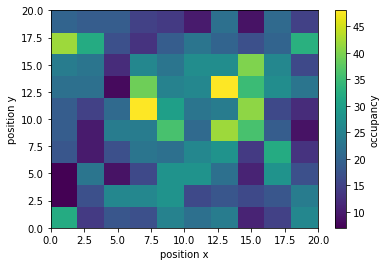

In [30]:
# 2d plot of the position distribution

a = []
for i in range(steps):
    for j in range(number_of_particles):
        a.append((data_traj)[j, 0, i])
b = []
for i in range(steps):
    for j in range(number_of_particles):
        b.append((data_traj)[j, 1, i])
    

plt.hist2d(a, b, range=[[0,box[0]],[0,box[1]]], bins=10)
plt.xlabel('position x')
plt.ylabel('position y')
plt.colorbar().set_label('occupancy')
plt.show()

**Interpretation:**
* in the reduced data projection, the occupancy of each bin seems even and well-distributed
* in the full dimensional projection, it can be seen easily that the box is **not** fully sampled, large undersampled patches present
* *data dimensionality reduction always brings the danger of wrong projection!*

**Solution for improvements:**
* enhance sampling by
    * prolong the simulation
    * increase the time step
* *Caveat: all solutions come with problems like increased computational cost or sampling errors!*